# Feature Multiplicity in SAEs

In [2]:
import json
from sae_lens import SAE, HookedSAETransformer
from transformer_lens import HookedTransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
)
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random
from utils import *

In IPython
Set autoreload


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
hf_cache = os.environ.get("HF_HOME", None)
print(f"Using Hugging Face cache directory: {hf_cache}")

Using device: cuda
Using Hugging Face cache directory: /work/pi_jensen_umass_edu/svaidyanatha_umass_edu/huggingface


In [4]:
# Load the model
model_name = "google/gemma-2-2b"  # Replace with the desired model name
print(f"Loading model: {model_name}...")
model = HookedSAETransformer.from_pretrained(model_name, device=device, cache_dir=hf_cache)

Loading model: google/gemma-2-2b...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [133]:
import json

# Change dir
os.chdir("/work/pi_jensen_umass_edu/svaidyanatha_umass_edu/projects/feature-multiplicity")
print(f"Current working directory: {os.getcwd()}")

# Load IOI datasets in English, Spanish, French, and German
eng_ioi_dataset = json.load(open("./data/ioi/eng_ioi.json"))
spa_ioi_dataset = json.load(open("./data/ioi/esp_ioi.json"))
fra_ioi_dataset = json.load(open("./data/ioi/fra_ioi.json"))
deu_ioi_dataset = json.load(open("./data/ioi/deu_ioi.json"))
datasets = {
    "English": eng_ioi_dataset,
    "Spanish": spa_ioi_dataset,
    "French": fra_ioi_dataset,
    "German": deu_ioi_dataset,
}

Current working directory: /work/pi_jensen_umass_edu/svaidyanatha_umass_edu/projects/feature-multiplicity


In [44]:
# Test performance of Gemma2-2B on IOI datasets

def get_logit_diff(logits, answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean().item()

num_samples = 10

for lang, dataset in datasets.items():
    print(f"Language: {lang}")
    print(f"Number of samples: {len(dataset)}")

    # Print language
    clean_prefixes = [item["clean_prefix"] for item in dataset][:num_samples]
    patch_prefixes = [item["patch_prefix"] for item in dataset][:num_samples]
    clean_answers = [item["clean_answer"] for item in dataset][:num_samples]
    patch_answers = [item["patch_answer"] for item in dataset][:num_samples]
    answers = [(clean_answer, patch_answer) for clean_answer, patch_answer in zip(clean_answers, patch_answers)]

    clean_tokens = model.to_tokens(clean_prefixes)
    patch_tokens = model.to_tokens(patch_prefixes)

    answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(clean_answers))], device=model.cfg.device)
    answer_tokens = model.tokenizer.decode(answer_token_indices.flatten().tolist())

    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    patch_logits, patch_cache = model.run_with_cache(patch_tokens)

    clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices)
    print(f"Clean logit diff: {clean_logit_diff:.4f}")

    patch_logit_diff = get_logit_diff(patch_logits, answer_token_indices)
    print(f"Patch logit diff: {patch_logit_diff:.4f}")

    CLEAN_BASELINE = clean_logit_diff
    PATCH_BASELINE = patch_logit_diff
    def ioi_metric(logits, answer_token_indices=answer_token_indices):
        return (get_logit_diff(logits, answer_token_indices) - PATCH_BASELINE) / (CLEAN_BASELINE  - PATCH_BASELINE)

    print(f"Clean Baseline is 1: {ioi_metric(clean_logits):.4f}")
    print(f"Corrupted Baseline is 0: {ioi_metric(patch_logits):.4f}")
    print("")

    cleanup_cuda()

    

Language: English
Number of samples: 303
Clean logit diff: 4.5057
Patch logit diff: -0.7616
Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000

Language: Spanish
Number of samples: 303
Clean logit diff: 2.9888
Patch logit diff: -0.8844
Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000

Language: French
Number of samples: 303
Clean logit diff: 3.7662
Patch logit diff: -0.9847
Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000

Language: German
Number of samples: 303
Clean logit diff: 2.9571
Patch logit diff: -2.1695
Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000



In [ ]:
# Test performance of SAE on the same task

from transformer_lens.utils import test_prompt

layer = 10

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res-canonical",
    sae_id=f"layer_{layer}/width_16k/canonical",
    device=str(device),
)

for lang, dataset in datasets.items():
    print(f"Language: {lang}")

    prompt = dataset[0]["clean_prefix"]
    answer = dataset[0]["clean_answer"]

    # First see how the model does without SAEs
    test_prompt(prompt, answer, model)

    # Test our prompt, to see what the model says
    with model.saes(saes=[sae]):
        test_prompt(prompt, answer, model)

    # Same thing, done in a different way
    model.add_sae(sae)
    test_prompt(prompt, answer, model)
    model.reset_saes()  # Remember to always do this!

    # Using `run_with_saes` method in place of standard forward pass
    logits = model(prompt, return_type="logits")
    logits_sae = model.run_with_saes(prompt, saes=[sae], return_type="logits")
    answer_token_id = model.to_single_token(answer)

    # Getting model's prediction
    top_prob, token_id_prediction = logits[0, -1].softmax(-1).max(-1)
    top_prob_sae, token_id_prediction_sae = logits_sae[0, -1].softmax(-1).max(-1)

    print(f"""Standard model: top prediction = {model.to_string(token_id_prediction)!r}, prob = {top_prob.item():.2%}
    SAE reconstruction: top prediction = {model.to_string(token_id_prediction_sae)!r}, prob = {top_prob_sae.item():.2%}
    """)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------")

Language: English
Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 48.86% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 48.86% Token: | Erica|
Top 1th token. Logit: 27.13 Prob: 24.31% Token: | the|
Top 2th token. Logit: 25.85 Prob:  6.74% Token: | his|
Top 3th token. Logit: 25.82 Prob:  6.55% Token: | a|
Top 4th token. Logit: 24.17 Prob:  1.26% Token: | Dr|
Top 5th token. Logit: 24.15 Prob:  1.23% Token: | her|
Top 6th token. Logit: 23.89 Prob:  0.95% Token: | an|
Top 7th token. Logit: 23.07 Prob:  0.42% Token: | him|
Top 8th token. Logit: 23.04 Prob:  0.41% Token: | Eric|
Top 9th token. Logit: 22.90 Prob:  0.35% Token: | nurse|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 52.12% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 52.12% Token: | Erica|
Top 1th token. Logit: 26.84 Prob: 19.29% Token: | the|
Top 2th token. Logit: 26.21 Prob: 10.31% Token: | Richard|
Top 3th token. Logit: 25.57 Prob:  5.42% Token: | his|
Top 4th token. Logit: 25.18 Prob:  3.68% Token: | a|
Top 5th token. Logit: 24.10 Prob:  1.24% Token: | him|
Top 6th token. Logit: 23.93 Prob:  1.05% Token: | her|
Top 7th token. Logit: 23.19 Prob:  0.50% Token: | an|
Top 8th token. Logit: 22.84 Prob:  0.35% Token: | himself|
Top 9th token. Logit: 22.80 Prob:  0.34% Token: | each|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Then', ',', ' Richard', ' and', ' Erica', ' went', ' to', ' the', ' hospital', '.', ' Richard', ' gave', ' a', ' drink', ' to']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.83 Prob: 52.12% Token: | Erica|

Top 0th token. Logit: 27.83 Prob: 52.12% Token: | Erica|
Top 1th token. Logit: 26.84 Prob: 19.29% Token: | the|
Top 2th token. Logit: 26.21 Prob: 10.31% Token: | Richard|
Top 3th token. Logit: 25.57 Prob:  5.42% Token: | his|
Top 4th token. Logit: 25.18 Prob:  3.68% Token: | a|
Top 5th token. Logit: 24.10 Prob:  1.24% Token: | him|
Top 6th token. Logit: 23.93 Prob:  1.05% Token: | her|
Top 7th token. Logit: 23.19 Prob:  0.50% Token: | an|
Top 8th token. Logit: 22.84 Prob:  0.35% Token: | himself|
Top 9th token. Logit: 22.80 Prob:  0.34% Token: | each|


Ranks of the answer tokens: [(' Erica', 0)]

Standard model: top prediction = ' Erica', prob = 48.86%
    SAE reconstruction: top prediction = ' Erica', prob = 52.12%
    
------------------------------------------------------------------------------------------------------------------------------------------------------------
Language: Spanish
Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.50 Prob: 54.37% Token: | Erica|

Top 0th token. Logit: 26.50 Prob: 54.37% Token: | Erica|
Top 1th token. Logit: 25.21 Prob: 15.00% Token: | su|
Top 2th token. Logit: 24.77 Prob:  9.68% Token: | la|
Top 3th token. Logit: 23.19 Prob:  1.99% Token: | un|
Top 4th token. Logit: 22.74 Prob:  1.27% Token: | una|
Top 5th token. Logit: 22.72 Prob:  1.24% Token: | los|
Top 6th token. Logit: 22.63 Prob:  1.13% Token: | Eric|
Top 7th token. Logit: 22.51 Prob:  1.00% Token: | Richard|
Top 8th token. Logit: 22.21 Prob:  0.75% Token: | sus|
Top 9th token. Logit: 21.55 Prob:  0.39% Token: | ella|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 1        Logit: 23.82 Prob: 19.08% Token: | Erica|

Top 0th token. Logit: 24.74 Prob: 47.67% Token: | Richard|
Top 1th token. Logit: 23.82 Prob: 19.08% Token: | Erica|
Top 2th token. Logit: 23.24 Prob: 10.63% Token: | la|
Top 3th token. Logit: 22.58 Prob:  5.53% Token: | su|
Top 4th token. Logit: 21.10 Prob:  1.25% Token: | los|
Top 5th token. Logit: 20.95 Prob:  1.09% Token: | las|
Top 6th token. Logit: 20.32 Prob:  0.57% Token: | un|
Top 7th token. Logit: 20.18 Prob:  0.50% Token: | una|
Top 8th token. Logit: 19.74 Prob:  0.32% Token: | Becker|
Top 9th token. Logit: 19.36 Prob:  0.22% Token: |́|


Ranks of the answer tokens: [(' Erica', 1)]

Tokenized prompt: ['<bos>', 'Luego', ',', ' Richard', ' y', ' Erica', ' fueron', ' al', ' hospital', '.', ' Richard', ' le', ' dio', ' una', ' bebida', ' a']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 1        Logit: 23.82 Prob: 19.08% Token: | Erica|

Top 0th token. Logit: 24.74 Prob: 47.67% Token: | Richard|
Top 1th token. Logit: 23.82 Prob: 19.08% Token: | Erica|
Top 2th token. Logit: 23.24 Prob: 10.63% Token: | la|
Top 3th token. Logit: 22.58 Prob:  5.53% Token: | su|
Top 4th token. Logit: 21.10 Prob:  1.25% Token: | los|
Top 5th token. Logit: 20.95 Prob:  1.09% Token: | las|
Top 6th token. Logit: 20.32 Prob:  0.57% Token: | un|
Top 7th token. Logit: 20.18 Prob:  0.50% Token: | una|
Top 8th token. Logit: 19.74 Prob:  0.32% Token: | Becker|
Top 9th token. Logit: 19.36 Prob:  0.22% Token: |́|


Ranks of the answer tokens: [(' Erica', 1)]

Standard model: top prediction = ' Erica', prob = 54.37%
    SAE reconstruction: top prediction = ' Richard', prob = 47.67%
    
------------------------------------------------------------------------------------------------------------------------------------------------------------
Language: French
Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 27.41 Prob: 72.81% Token: | Erica|

Top 0th token. Logit: 27.41 Prob: 72.81% Token: | Erica|
Top 1th token. Logit: 25.05 Prob:  6.88% Token: | son|
Top 2th token. Logit: 24.32 Prob:  3.31% Token: | l|
Top 3th token. Logit: 24.24 Prob:  3.06% Token: | la|
Top 4th token. Logit: 24.04 Prob:  2.50% Token: | sa|
Top 5th token. Logit: 23.75 Prob:  1.88% Token: | un|
Top 6th token. Logit: 23.43 Prob:  1.36% Token: |Erica|
Top 7th token. Logit: 23.04 Prob:  0.92% Token: | une|
Top 8th token. Logit: 22.59 Prob:  0.59% Token: | Eric|
Top 9th token. Logit: 21.89 Prob:  0.29% Token: | É|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.21 Prob: 72.70% Token: | Erica|

Top 0th token. Logit: 26.21 Prob: 72.70% Token: | Erica|
Top 1th token. Logit: 23.67 Prob:  5.76% Token: | Richard|
Top 2th token. Logit: 23.56 Prob:  5.12% Token: | l|
Top 3th token. Logit: 23.31 Prob:  4.01% Token: | la|
Top 4th token. Logit: 22.63 Prob:  2.02% Token: | son|
Top 5th token. Logit: 22.46 Prob:  1.71% Token: | sa|
Top 6th token. Logit: 22.26 Prob:  1.40% Token: | un|
Top 7th token. Logit: 21.59 Prob:  0.71% Token: | une|
Top 8th token. Logit: 21.25 Prob:  0.51% Token: |Erica|
Top 9th token. Logit: 21.02 Prob:  0.40% Token: | ses|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Ensuite', ',', ' Richard', ' et', ' Erica', ' sont', ' all', 'és', ' à', ' l', "'", 'hôpital', '.', ' Richard', ' a', ' donné', ' une', ' boisson', ' à']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.21 Prob: 72.70% Token: | Erica|

Top 0th token. Logit: 26.21 Prob: 72.70% Token: | Erica|
Top 1th token. Logit: 23.67 Prob:  5.76% Token: | Richard|
Top 2th token. Logit: 23.56 Prob:  5.12% Token: | l|
Top 3th token. Logit: 23.31 Prob:  4.01% Token: | la|
Top 4th token. Logit: 22.63 Prob:  2.02% Token: | son|
Top 5th token. Logit: 22.46 Prob:  1.71% Token: | sa|
Top 6th token. Logit: 22.26 Prob:  1.40% Token: | un|
Top 7th token. Logit: 21.59 Prob:  0.71% Token: | une|
Top 8th token. Logit: 21.25 Prob:  0.51% Token: |Erica|
Top 9th token. Logit: 21.02 Prob:  0.40% Token: | ses|


Ranks of the answer tokens: [(' Erica', 0)]

Standard model: top prediction = ' Erica', prob = 72.81%
    SAE reconstruction: top prediction = ' Erica', prob = 72.70%
    
------------------------------------------------------------------------------------------------------------------------------------------------------------
Language: German
Tokenized prompt: ['<bos>', 'Dann', ' gingen', ' Richard', ' und', ' Erica', ' ins', ' Krankenhaus', '.', ' Richard', ' gab', ' ein', ' Get', 'ränk', ' an']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 26.76 Prob: 40.45% Token: | Erica|

Top 0th token. Logit: 26.76 Prob: 40.45% Token: | Erica|
Top 1th token. Logit: 25.51 Prob: 11.49% Token: | die|
Top 2th token. Logit: 25.47 Prob: 11.08% Token: |,|
Top 3th token. Logit: 25.05 Prob:  7.26% Token: | den|
Top 4th token. Logit: 24.78 Prob:  5.56% Token: | und|
Top 5th token. Logit: 24.35 Prob:  3.61% Token: |.|
Top 6th token. Logit: 24.12 Prob:  2.87% Token: | der|
Top 7th token. Logit: 23.65 Prob:  1.79% Token: | das|
Top 8th token. Logit: 23.23 Prob:  1.18% Token: | einen|
Top 9th token. Logit: 23.08 Prob:  1.01% Token: | seine|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Dann', ' gingen', ' Richard', ' und', ' Erica', ' ins', ' Krankenhaus', '.', ' Richard', ' gab', ' ein', ' Get', 'ränk', ' an']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 24.46 Prob: 20.83% Token: | Erica|

Top 0th token. Logit: 24.46 Prob: 20.83% Token: | Erica|
Top 1th token. Logit: 24.40 Prob: 19.61% Token: |,|
Top 2th token. Logit: 24.33 Prob: 18.27% Token: |.|
Top 3th token. Logit: 23.57 Prob:  8.62% Token: | der|
Top 4th token. Logit: 23.38 Prob:  7.06% Token: | die|
Top 5th token. Logit: 23.17 Prob:  5.73% Token: | den|
Top 6th token. Logit: 23.16 Prob:  5.70% Token: | und|
Top 7th token. Logit: 21.65 Prob:  1.25% Token: | das|
Top 8th token. Logit: 21.25 Prob:  0.84% Token: | Richard|
Top 9th token. Logit: 21.15 Prob:  0.76% Token: |.\|


Ranks of the answer tokens: [(' Erica', 0)]

Tokenized prompt: ['<bos>', 'Dann', ' gingen', ' Richard', ' und', ' Erica', ' ins', ' Krankenhaus', '.', ' Richard', ' gab', ' ein', ' Get', 'ränk', ' an']
Tokenized answer: [' Erica']


Performance on answer token:
Rank: 0        Logit: 24.46 Prob: 20.83% Token: | Erica|

Top 0th token. Logit: 24.46 Prob: 20.83% Token: | Erica|
Top 1th token. Logit: 24.40 Prob: 19.61% Token: |,|
Top 2th token. Logit: 24.33 Prob: 18.27% Token: |.|
Top 3th token. Logit: 23.57 Prob:  8.62% Token: | der|
Top 4th token. Logit: 23.38 Prob:  7.06% Token: | die|
Top 5th token. Logit: 23.17 Prob:  5.73% Token: | den|
Top 6th token. Logit: 23.16 Prob:  5.70% Token: | und|
Top 7th token. Logit: 21.65 Prob:  1.25% Token: | das|
Top 8th token. Logit: 21.25 Prob:  0.84% Token: | Richard|
Top 9th token. Logit: 21.15 Prob:  0.76% Token: |.\|


Ranks of the answer tokens: [(' Erica', 0)]

Standard model: top prediction = ' Erica', prob = 40.45%
    SAE reconstruction: top prediction = ' Erica', prob = 20.83%
    
------------------------------------------------------------------------------------------------------------------------------------------------------------


In [57]:
from IPython.display import IFrame, display
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

def display_dashboard(
    sae_release="gemma-scope-2b-pt-res-canonical",
    sae_id="layer_10/width_16k/canonical",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))

In [65]:
import plotly.express as px

lang = "Spanish"
prompt = datasets[lang][0]["clean_prefix"]

print(prompt)

# Get top activations on final token
_, cache = model.run_with_cache_with_saes(
    prompt,
    saes=[sae],
    stop_at_layer=sae.cfg.hook_layer + 1,
)
sae_acts_post = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"][0, -1, :]

# Plot line chart of latent activations
px.line(
    sae_acts_post.cpu().numpy(),
    title=f"Latent activations at the final token position ({sae_acts_post.nonzero().numel()} alive)",
    labels={"index": "Latent", "value": "Activation"},
    width=1000,
).update_layout(showlegend=False).show()

# Print the top 5 latents, and inspect their dashboards
for act, ind in zip(*sae_acts_post.topk(3)):
    print(f"Latent {ind} had activation {act:.2f}")
    display_dashboard(latent_idx=ind)

Luego, Richard y Erica fueron al hospital. Richard le dio una bebida a


Latent 8383 had activation 24.86
https://neuronpedia.org/gemma-2-2b/10-gemmascope-res-16k/8383?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 3986 had activation 22.07
https://neuronpedia.org/gemma-2-2b/10-gemmascope-res-16k/3986?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


Latent 10680 had activation 11.54
https://neuronpedia.org/gemma-2-2b/10-gemmascope-res-16k/10680?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


# Attribution Patching with Integrated Gradients

In [80]:
from utils import *
from torch.nn import functional as F
from utils import run_sae_hook_fn

def get_zero_atp_ig_effect(model, saes, sae_idx, toks, labels, ig_steps):
    with torch.no_grad():
        _, saes = run_sae_hook_fn(model, saes, toks, cache_sae_activations=True)
        clean_acts = [s.feature_acts for s in saes]
        cleanup_cuda()   
    sae_clean_acts = clean_acts[sae_idx]
    sae_corr_acts = torch.zeros_like(sae_clean_acts)

    ratios = [i/ig_steps for i in range(ig_steps)]
    effects = []
    for ratio in tqdm(ratios): 
        # get interpolated activations and logits between clean and zero 
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out, saes = run_sae_hook_fn(model, saes, toks, fake_activations=(saes[sae_idx].cfg.hook_layer,interpolation))

        # metric is prob of correct tok
        answer_logits = interpolated_out[..., -1, :]
        answer_logprobs = F.softmax(answer_logits, dim=-1)
        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels]
        metric = torch.sum(clean_logprobs)
        metric.backward()

        # attr formula
        counterfactual_delta = sae_clean_acts - sae_corr_acts
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)
        effects.append(effect)
        cleanup_cuda()

    effects = torch.stack(effects)
    clear_memory(saes, model)
    final_effect = effects.mean(dim=0)
    return model, saes, final_effect

In [ ]:
languages = datasets.keys()
data_batches = {lang: {"prompts": [], "answers": []} for lang in languages}
important_token_positions = {lang: {"S1": [], "IO": [], "S2": [], "PLACE": [], "OBJECT": []} for lang in languages}
n_samples = 50
seed = 42
random.seed(seed)
prompt_idxs = list(range(len(datasets["English"])))
random.shuffle(prompt_idxs)

for lang in languages:
    prompts = [item["clean_prefix"] for item in datasets[lang]]
    answers = [item["clean_answer"] for item in datasets[lang]]

    # Find the set of prompt lengths and counts for each prompt length
    prompt_lengths, counts = np.unique([len(model.to_tokens(prompt)) for prompt in prompts], return_counts=True)
    
    # Pick the most frequently occurring length
    assert max(counts) >= n_samples, f"Cannot produce dataset of size {n_samples} with fixed prompt length"
    fixed_len = prompt_lengths[np.argmax(counts)]
    prompt_idxs = [i for i in prompt_idxs if len(model.to_tokens(prompts[i])) == fixed_len]

    patch_answers = [item["patch_answer"] for item in datasets[lang]]
    data_batches[lang] = {"prompts": [prompts[i] for i in prompt_idxs[:n_samples]], 
                          "answers": [answers[i] for i in prompt_idxs[:n_samples]], 
                          "patch_answers": [patch_answers[i] for i in prompt_idxs[:n_samples]]
                          }
    
# Print a few examples from each dataset
for lang in languages:
    print(f"Language: {lang}")
    for i in range(3):
        print(f"Prompt: {data_batches[lang]['prompts'][i]}")
        print(f"Answer: {data_batches[lang]['answers'][i]}")
        print(f"Patch Answer: {data_batches[lang]['patch_answers'][i]}")
        print("")

# Store a few important token positions, we will use this later

def get_important_token_positions(data_batches):
    important_token_positions = {lang: {"S1": [], "IO": [], "S2": [], "PLACE": [], "OBJECT": []} for lang in data_batches.keys()}
    for lang in data_batches.keys():
        for i, prompt in enumerate(data_batches[lang]["prompts"]):
            tokens = model.to_tokens(prompt)
            tokenized_string = model.tokenizer.decode(tokens)

            s_tokens = [f"{patch_answers[i]}", f" {patch_answers[i]}"]
            s_token_positions = [t for t in tokens if t in s_tokens]
            assert(len(s_token_positions) == 2)
            important_token_positions[lang]["S1"].append(s_token_positions[0])
            important_token_positions[lang]["S2"].append(s_token_positions[1])

            io_token_position = [f"{answers[i]}", f" {answers[i]}"]
            io_token_positions = [t for t in tokens if t in io_token_position]
            assert(len(io_token_positions) == 1)
            important_token_positions[lang]["IO"].append(io_token_positions[0])

    return important_token_positions

FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED French: [17, 18, 19, 20]
FAILED F

KeyboardInterrupt: 

In [149]:
for lang, data in data_batches.items():
    print(f"Language: {lang}")
    for prompt in data["prompts"][:5]:
        print(prompt)
    print("")

Language: English
Then, Alexander and Jamie went to the store. Alexander gave a drink to
Then, Amber and Amy went to the office. Amber gave a computer to
Then, Kimberly and Jeffrey went to the office. Kimberly gave a ring to
Then, Christopher and Jennifer went to the house. Christopher gave a necklace to
Then, Michael and Sarah went to the station. Michael gave a kiss to

Language: Spanish
Luego, Alexander y Jamie fueron a la tienda. Alexander le dio una bebida a
Luego, Amber y Amy fueron a la oficina. Amber le dio una computadora a
Luego, Kimberly y Jeffrey fueron a la oficina. Kimberly le dio un anillo a
Luego, Christopher y Jennifer fueron a la casa. Christopher le dio un collar a
Luego, Michael y Sarah fueron a la estación. Michael le dio un beso a

Language: French
Ensuite, Alexander et Jamie sont allés au magasin. Alexander a donné une boisson à
Ensuite, Amber et Amy sont allées au bureau. Amber a donné un ordinateur à
Ensuite, Kimberly et Jeffrey sont allées au bureau. Kimberly 

In [ ]:
# Run attribution patching

cleanup_cuda()
lang = "Spanish"
saes = [sae]
sae_idx = 0
ig_steps = 10
toks = model.to_tokens(prompts)
labels = [model.to_single_token(answer) for answer in answers]

model, saes, effect = get_zero_atp_ig_effect(model, saes, sae_idx, toks, labels, ig_steps)
effect = effect.cpu().numpy()
print(effect.shape)

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

(19, 16384)


In [121]:
# We are just looking at the S2 token
s2_positions = {
    "English": 11,
    "Spanish": 11,
    "French": 14,
    "German": 9,
}

s2_pos = s2_positions[lang]
effect_s2 = effect[s2_pos]

# Decode tokens for first example
decoded_toks = model.tokenizer.decode(toks[2])
decoded_toks = decoded_toks.split()
print(decoded_toks)
print(len(decoded_toks))
print(effect_s2.shape)
      
# Prune out latents that have no effect and save their indices
epsilon = 1e-8
effect_idxs = np.where(effect_s2 > epsilon)[0]
effect_pruned = effect_s2[effect_idxs]

# Sort the pruned effects in descending order and keep the indices
sorted_idxs = np.argsort(-effect_pruned)
effect_pruned = effect_pruned[sorted_idxs]
effect_idxs = effect_idxs[sorted_idxs]
print(effect_pruned.shape)

['<bos>Luego,', 'Jason', 'y', 'Jamie', 'fueron', 'al', 'jardín.', 'Jason', 'le', 'dio', 'un', 'collar', 'a<pad><pad><pad>']
13
(16384,)
(377,)


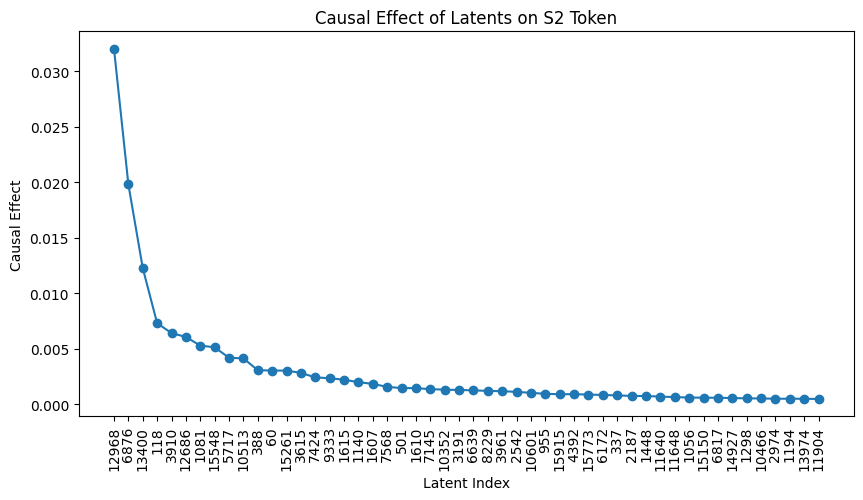

In [107]:
# Plot top 50 latents
num_latents = 50
plt.figure(figsize=(10, 5))
plt.plot(effect_pruned[:num_latents], marker="o")
plt.xticks(range(num_latents), [f"{idx}" for idx in effect_idxs[:num_latents]], rotation=90)
plt.xlabel("Latent Index")
plt.ylabel("Causal Effect")
plt.title("Causal Effect of Latents on S2 Token")
plt.show()

In [109]:
# Set threshold
threshold = 0.005
top_latent_idxs = effect_idxs[effect_pruned > threshold]
top_latent_effects = effect_pruned[effect_pruned > threshold]

# Print top latents with their causal effects
for idx, effect in zip(top_latent_idxs, top_latent_effects):
    print(f"Latent {idx}: {effect:.4f}")

Latent 12968: 0.0320
Latent 6876: 0.0198
Latent 13400: 0.0123
Latent 118: 0.0073
Latent 3910: 0.0064
Latent 12686: 0.0061
Latent 1081: 0.0053
Latent 15548: 0.0051
